In [1]:
import math
import struct

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import (Activation, Add,
                                            BatchNormalization, Convolution2D,
                                            Dense, Dropout, Flatten,
                                            GlobalAveragePooling2D, Input,
                                            Lambda, Multiply, concatenate)
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from keras.models import Model, load_model
from tensorflow.python.keras.optimizers import SGD, Adam, Adamax, nadam
from tensorflow.python.keras.utils import Sequence, to_categorical

from PIL import Image, ImageEnhance

Using TensorFlow backend.


In [2]:
class ETL9B:
    def __init__(self, path, num, label_num, drop_records=[], seek=0):
        self.labels = label_num
        self.max_nums = num
        self.image_shape = [63, 64]
        self.filename = path
        self.drop_records = drop_records
        self.file = open(self.filename, 'rb')
        self.seek = seek
        
    def is_dropped(self, label, num):
        if self.drop_records:
            for drop_record in self.drop_records:
                if drop_record[0] == label and drop_record[1] == num:
                    return True
        return False
    
    def _read(self, skip):
        record_size = 576
        self.file.seek(skip * record_size)
        s = self.file.read(record_size)
        r = struct.unpack('>2H4s504s64x', s)
        i1 = Image.frombytes('1', (64, 63), r[3], 'raw')
        return np.array(i1)
        
    def get_chars(self):
        images = []
        labels = []
        seek = self.seek
        for num in range(self.max_nums):
            for label in range(self.labels):
                if not self.is_dropped(label, num):
                    x = self._read(label + seek + self.labels*num)
                    images.append(x)
                    labels.append(label)
                else:
                    seek -= 1
        return np.asarray(images)[..., np.newaxis], to_categorical(np.asarray(labels), self.labels)

In [5]:
etl9b_path = '/Users/chai/data/etlcdb/ETL9B/'
etl9b_x = []
etl9b_y = []
for i in range(5):
    x, y = ETL9B(etl9b_path + 'ETL9B_' + str(i+1), 40, 3036, seek=1).get_chars()
    etl9b_x.extend(x)
    etl9b_y.extend(y)
etl9b = [np.asarray(etl9b_x), np.asarray(etl9b_y)]

In [ ]:
etl9b[0].shape

In [7]:
batch_size = 30
num_class = 3036
split_num = 546480
train_data = [etl9b[0][:split_num], etl9b[1][:split_num]]
test_data = [etl9b[0][split_num:], etl9b[1][split_num:]]
# train_data_seq = ETL_sequence(train_data, batch_size, num_class)
# test_data_seq = ETL_sequence(test_data, batch_size, num_class)

In [8]:
model = load_model('model.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 63, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 63, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 63, 64, 64)   9280        conv2d_2[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 64)           0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

/Users/chai/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


model.evaluate(test_data[0], test_data[1])

In [42]:
num = 1414 + 3036*17
label = num%3036
pred = model.predict(test_data[0][num].reshape([1, 63, 64, 1]))
pred_num = np.argmax(pred)
print(pred[0, pred_num])
if pred_num == label:
    print('g')
else:
    print('b')

0.9999701
g


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


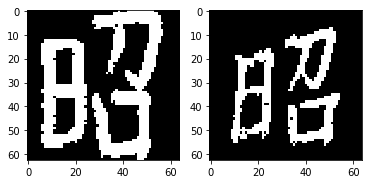

In [43]:
cop = [test_data[0][num], train_data[0][pred_num]]
cop = np.squeeze(cop)
print(test_data[1][num])
print(train_data[1][num])
for i in range(2):
    im = cop[i]
    
    num = 330 + i + 1
    plt.subplot(1, 2, i + 1)
    plt.gray()
    plt.imshow(im)
plt.show()